In [1]:
# Built-in
import os
import math
import itertools
import multiprocessing
import statistics

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.cluster as clustering
from tslearn.clustering import KShape
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

# Overhead

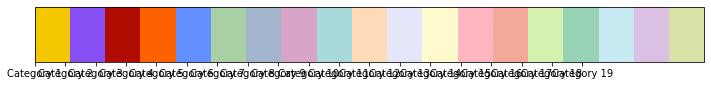

In [4]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

In [5]:
grouped_colors = colors_19[0:3]
grouped_color_order = ['PT', 'IT', 'CIN']

In [6]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

In [7]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [8]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [9]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [10]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [11]:
lump_excitatory = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','L5/6-IT','L5-PT']
lump_cin = ['CIN-PV','CIN-SST','CIN-VIP']

In [12]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [13]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

,id,name,color
1,1,L6-CT,#A9CFA4
7,7,L5-PT,#F4C700
2,2,L4/5-IT,#8650F5
3,3,L4-IT,#4F19BE
0,0,L2/3-IT,#7662A0
5,5,L5/6-IT,#BA98FF
11,12,CIN-VIP,#648FFF
8,8,CIN-PV,#B00B00
10,10,CIN-SST,#FE6100
4,4,Oligodendrocytes,#A3B5CC


In [14]:
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

In [15]:
this_figure_dir = f'{settings.fig_path}/figure_2_htr'
os.makedirs(this_figure_dir, exist_ok=True)

In [16]:
ctrl_adata = adata[adata.obs['drug'] == 'none'].copy()

In [17]:
htr_genes = ['Htr1a', 'Htr2a','Htr2c']

# Dotplots

only on control data

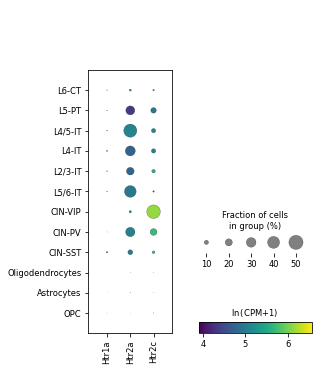

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(4,6))
sc.pl.dotplot(ctrl_adata, var_names=htr_genes, groupby='name',
              cmap='viridis', colorbar_title='$\ln$(CPM+1)',
              mean_only_expressed=True,
              ax=ax)
fig.savefig(f'{this_figure_dir}/htr_dotplot.png', dpi=600)
fig.savefig(f'{this_figure_dir}/htr_dotplot.pdf', dpi=600)

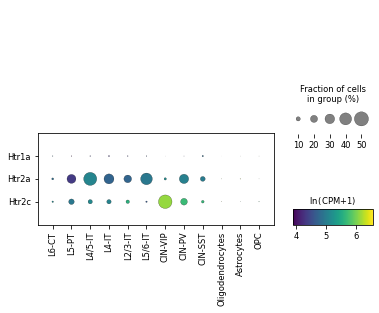

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sc.pl.dotplot(ctrl_adata, var_names=htr_genes, groupby='name',
              cmap='viridis', colorbar_title='$\ln$(CPM+1)',
              mean_only_expressed=True, swap_axes=True,
              ax=ax)
fig.savefig(f'{this_figure_dir}/htr_dotplot_horizontal.png', dpi=600)
fig.savefig(f'{this_figure_dir}/htr_dotplot_horizontal.pdf', dpi=600)

# Violins

In [18]:
# not trivial to do this in code
celltype_counts = ctrl_adata.obs['name'].value_counts()
celltype_counts

L2/3-IT             8478
L6-CT               7384
L4/5-IT             7228
Oligodendrocytes    4962
L4-IT               4615
L5/6-IT             3802
Astrocytes          2999
L5-PT               2568
CIN-PV              2540
OPC                 2154
CIN-SST             1744
CIN-VIP             1489
Name: name, dtype: int64

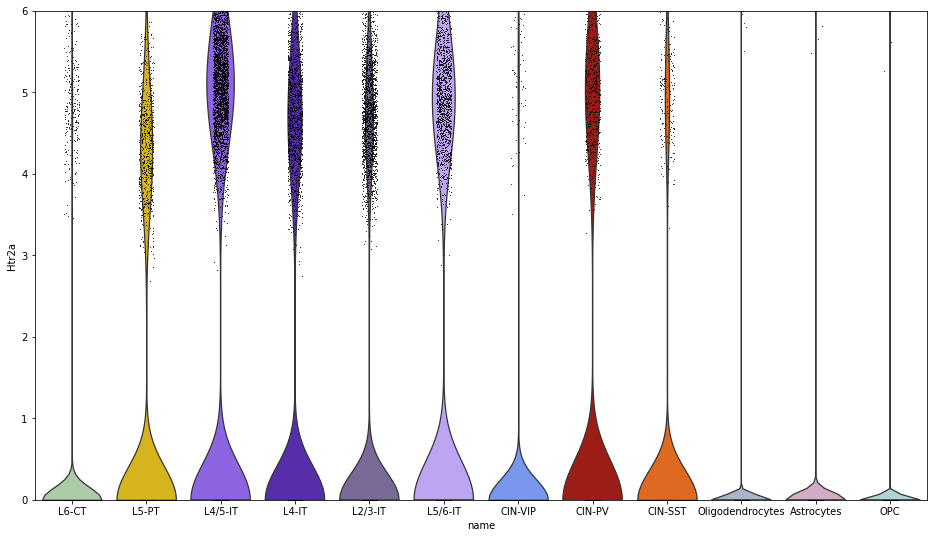

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
sc.pl.violin(ctrl_adata, 'Htr2a', groupby='name', ax=ax, show=False)
ax.set_ylim(0,6)
plt.show()

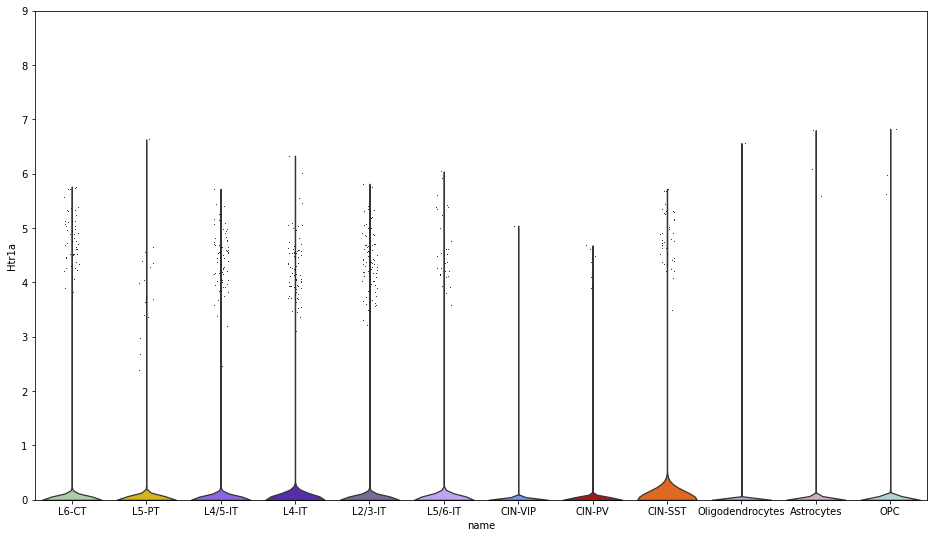

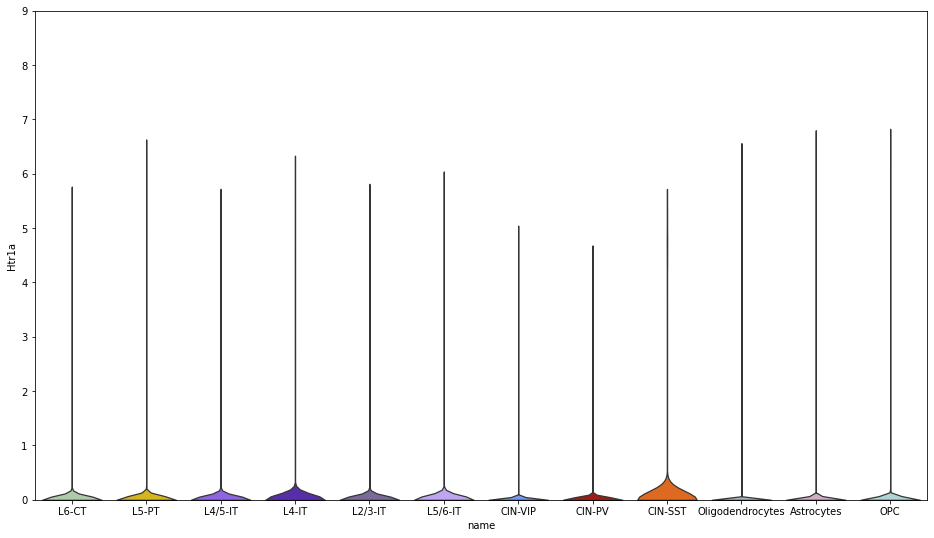

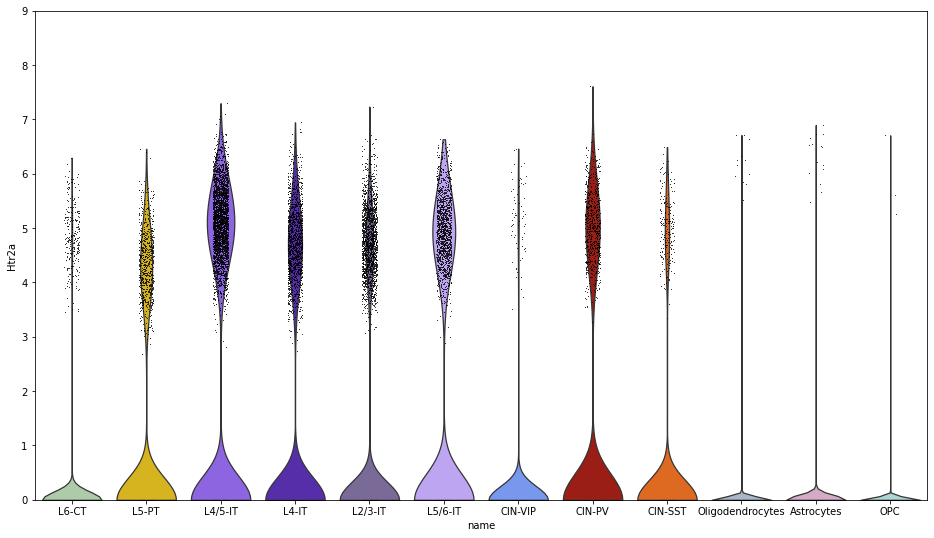

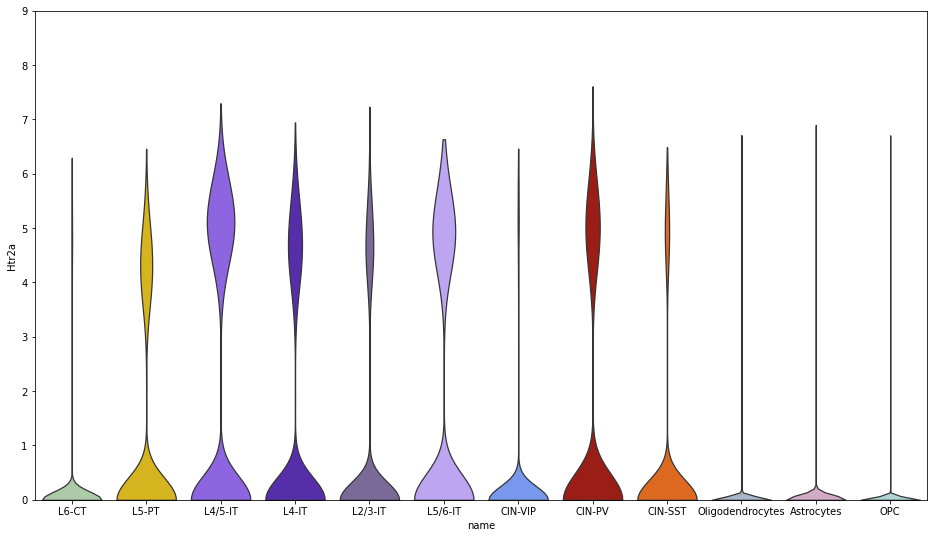

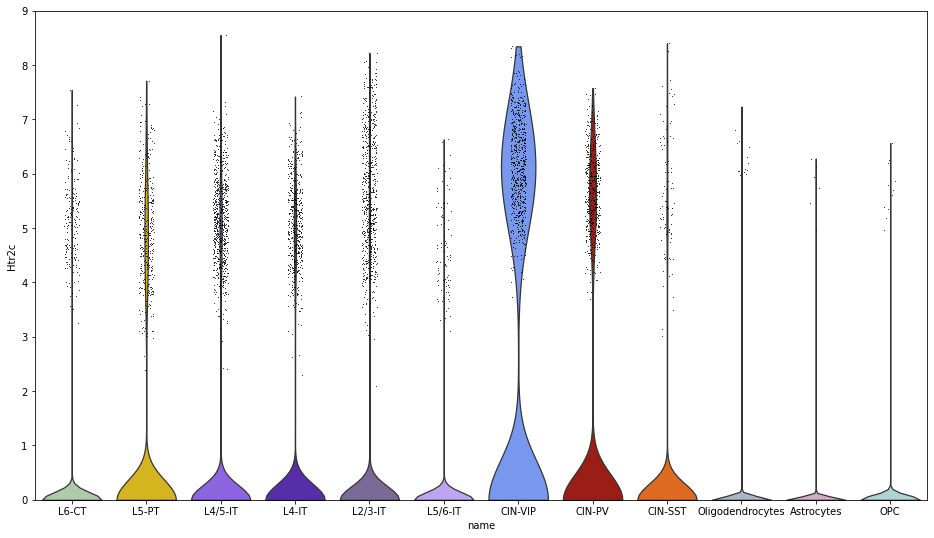

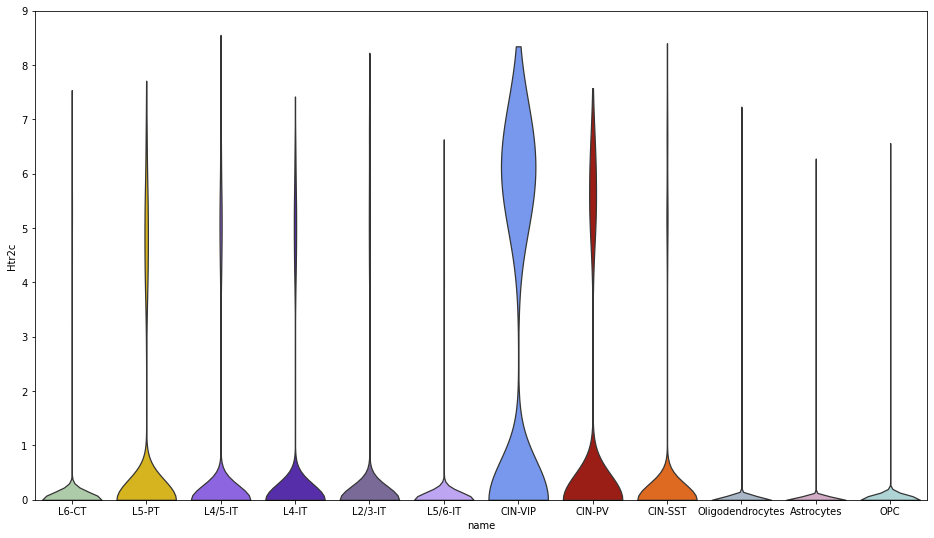

In [22]:
ymax = 9.0
for gene in htr_genes:
    fig, ax = plt.subplots(1, 1, figsize=(16,9))
    sc.pl.violin(ctrl_adata, gene, groupby='name', ax=ax, show=False)
    ax.set_ylim(0,ymax)
    fig.savefig(f'{this_figure_dir}/{gene}_violin.png', dpi=600)
    fig.savefig(f'{this_figure_dir}/{gene}_violin.pdf', dpi=600)
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(16,9))
    sc.pl.violin(ctrl_adata, gene, groupby='name', stripplot=False, ax=ax, show=False)
    ax.set_ylim(0,ymax)
    fig.savefig(f'{this_figure_dir}/{gene}_violin_nostrip.png', dpi=600)
    fig.savefig(f'{this_figure_dir}/{gene}_violin_nostrip.pdf', dpi=600)
    plt.show()

# UMAP

In [104]:
# Read h5 data
csc_data_path = '/nfs/turbo/umms-kykwan/projects/alex_kwan/figures/scanpy_cellranger_fixed_sex/gold-sc-cluster-expression.h5ad'
f = h5py.File(csc_data_path, 'r')

In [105]:
# LABEL_COLORS = f['uns/label_colors'][:].astype(str)
gene_index = list(f['var/gene_name'][:].astype(str))
SORTED_GENE_LIST = sorted(gene_index)
INDPTR = f['X']['indptr']

In [106]:
def column_from_codes_and_cats(group_name, desired_type):
    codes = f[f'obs/{group_name}/codes'][:]
    categories = f[f'obs/{group_name}/categories'][:]
    return pd.Categorical(values=codes).rename_categories(categories).to_numpy().astype(desired_type)

In [107]:
time = f['obs/time'][:]
drug = column_from_codes_and_cats('drug', 'str')
sex = column_from_codes_and_cats('sex', 'str')
leiden = column_from_codes_and_cats('leiden', 'str')
umap_coords = f['obsm/X_umap'][:]

cell_metadata = pd.DataFrame()
cell_metadata['time'] = time
cell_metadata['sex'] = sex
cell_metadata['drug'] = drug
cell_metadata['leiden'] = leiden
cell_metadata['umap_x'] = umap_coords[:,0]
cell_metadata['umap_y'] = umap_coords[:,1]

In [108]:
def get_sorted_observations(gene_name):
    col_idx = gene_index.index(gene_name)
    X_data = f['X/data'][INDPTR[col_idx] : INDPTR[col_idx+1]]
    X_data = X_data
    X_indices = f['X/indices'][INDPTR[col_idx] : INDPTR[col_idx+1]]
    sorted_obs = cell_metadata.copy()
    sorted_obs['expression'] = 0
    sorted_obs.loc[X_indices, 'expression'] = X_data
    sorted_obs = sorted_obs.sort_values('expression')
    return sorted_obs

In [109]:
get_sorted_observations('Htr2a')

,time,sex,drug,leiden,umap_x,umap_y,expression
0,0,F,none,1,15.010727,0.330866,0.000000
186033,1,F,Ket,1,15.583945,-0.433887,0.000000
186034,1,F,Ket,1,15.370452,0.875971,0.000000
186035,1,F,Ket,6,7.873463,-10.337101,0.000000
186036,1,F,Ket,12,11.277974,-1.956251,0.000000
...,...,...,...,...,...,...,...
32864,0,M,none,8,17.344149,6.619721,7.609375
282647,24,M,Ket,16,9.252684,11.081868,7.628906
100100,24,F,Psilo,16,8.418153,12.067457,7.683594
215555,4,F,Ket,2,12.872776,13.403153,7.730469


In [116]:
max_htr_expression = max([
    get_sorted_observations(gene).query('drug == "none"')['expression'].max()
    for gene in htr_genes
])
max_htr_expression

8.6015625

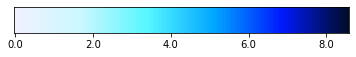

In [128]:
danzan_cols = [
    '#f2f1ff',
    '#caf8ff',
    '#55f7ff',
    '#00a6ff',
    '#001bff',
    '#000d2a',
]
danzan = LinearSegmentedColormap.from_list('danzan', danzan_cols)

gradient = np.linspace(0,1,256)
gradient = np.vstack((gradient, gradient))

expression_ticks = np.arange(0.0, max_htr_expression, 2.0)

plt.imshow(gradient, aspect=10, cmap=danzan)
plt.xticks(ticks = expression_ticks * 256 / max_htr_expression, labels = expression_ticks)
plt.yticks([])
plt.savefig(f'{this_figure_dir}/expression_colorbar.png')
plt.savefig(f'{this_figure_dir}/expression_colorbar.pdf')

In [122]:
np.arange(0.0, max_htr_expression, 2.0)

array([0., 2., 4., 6., 8.])

In [120]:
def manage_expression_subplot(ax, obs_metadata, title=''):
    """
    ax - Matplotlib Axis
    obs - dataframe filtered by drug to one of none,Ket,Psilo
    treatment - treament label for plot title
    """
    box = ax.scatter(
        x=obs_metadata['umap_x'], y=obs_metadata['umap_y'], 
        c=obs_metadata['expression'], cmap=danzan, alpha=1,
        vmin=0.0, vmax=max_htr_expression,
        marker='.', s=2
    )
    ax.set(
        xlabel='UMAP 1', ylabel='UMAP 2', 
        xticks=[], yticks=[]
    )
    ax.set_title(title, fontsize=20)
    return box

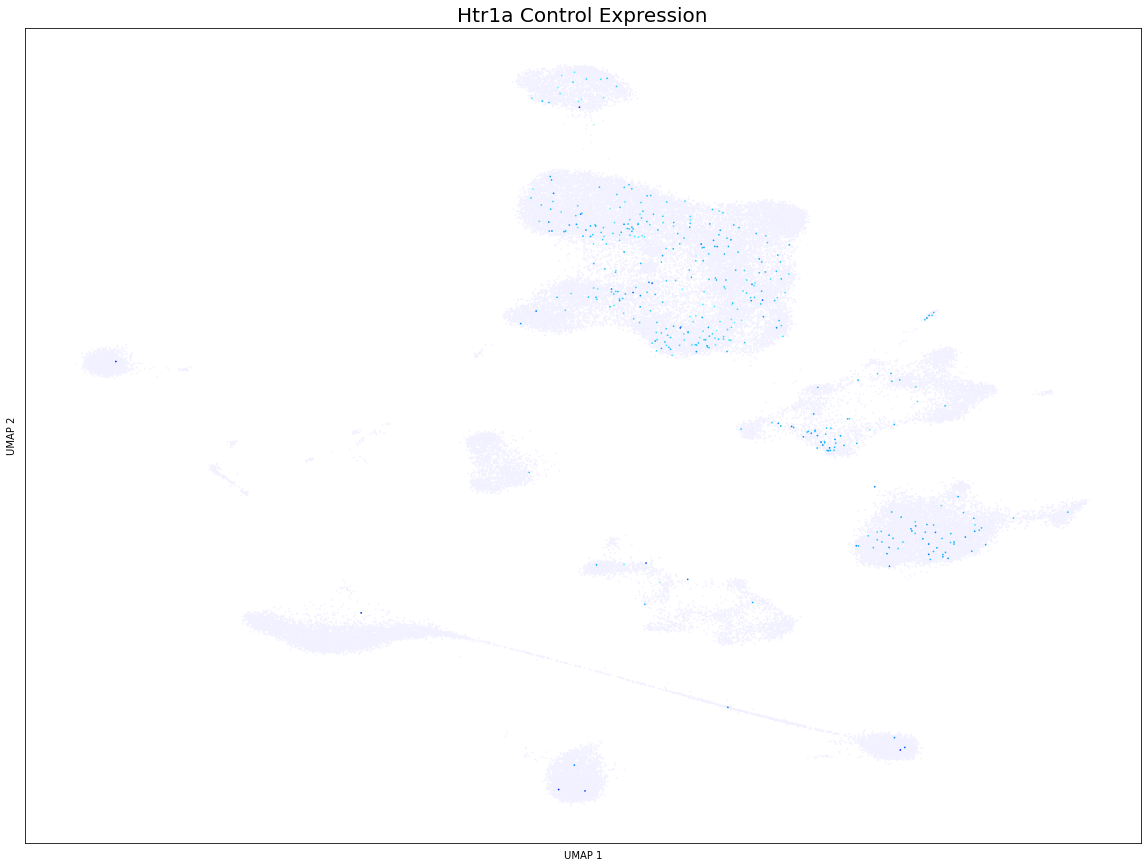

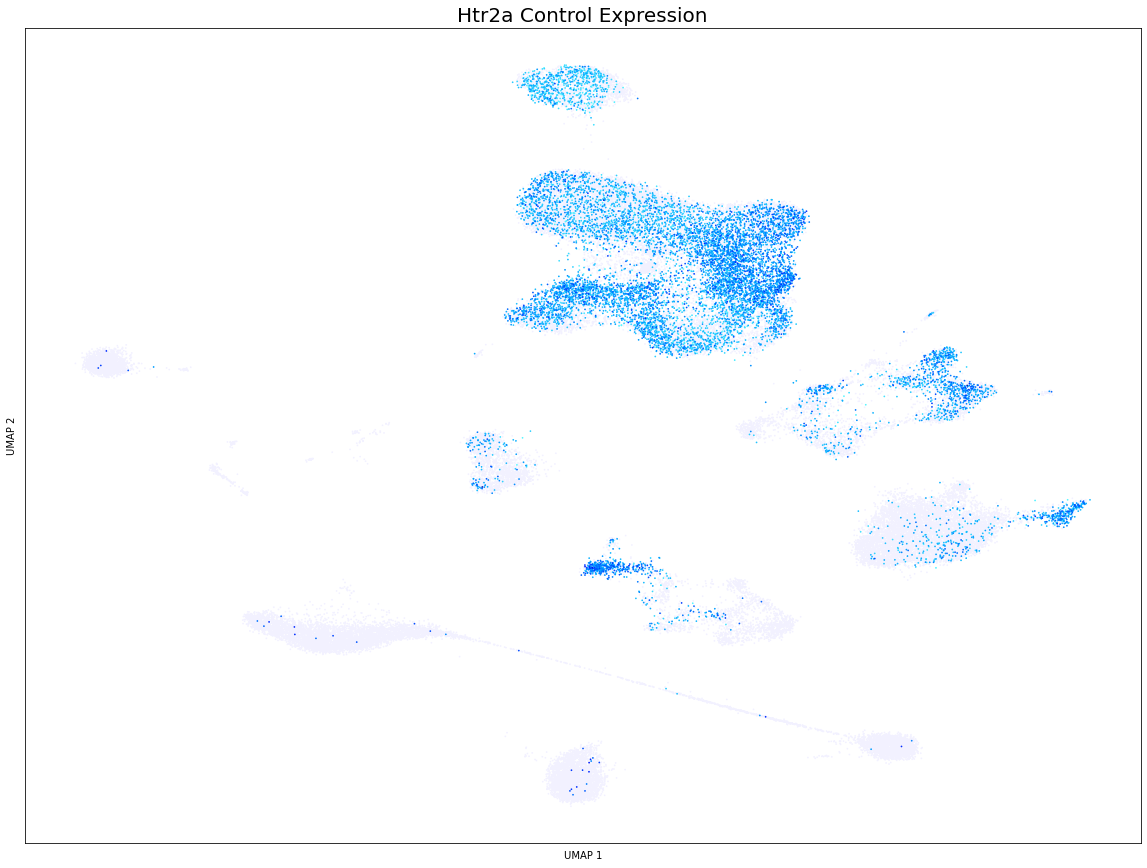

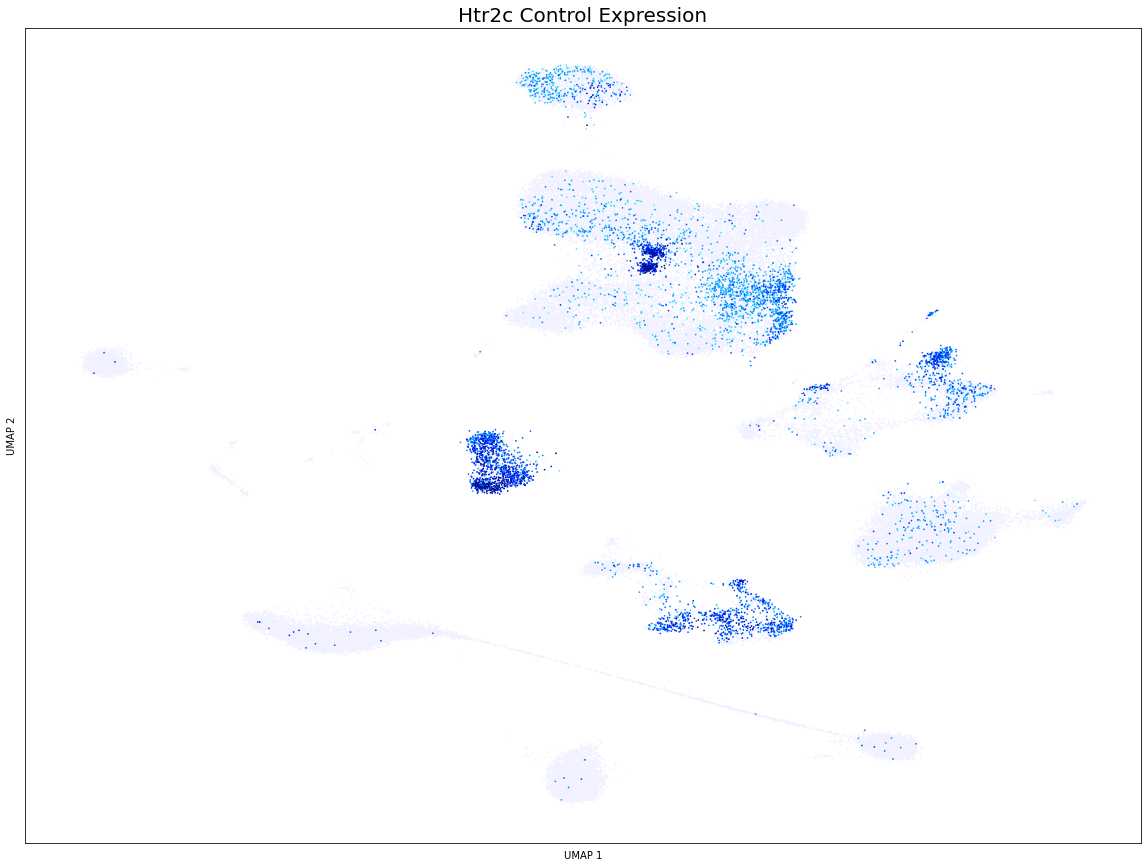

In [129]:
for gene in htr_genes:
    fig, ax = plt.subplots(1, 1, figsize=(20,15))
    manage_expression_subplot(ax, get_sorted_observations(gene).query('drug == "none"'), f'{gene} Control Expression')
    fig.savefig(f'{this_figure_dir}/ctrl_{gene}_umap.png', bbox_inches="tight")
    fig.savefig(f'{this_figure_dir}/ctrl_{gene}_umap.pdf', bbox_inches="tight")